In [ ]:
import tensorflow as tf

import tensorflow.keras.utils as utils

import tensorflow.keras.applications as applications

import tensorflow_datasets as tfds

tfds.disable_progress_bar()

import warnings; warnings.filterwarnings('ignore')

import os, pathlib

Load Dataset on TensorFlow Dataset

In [ ]:
inset = "cats_vs_dogs"

split = ["train[:10%]", "train[80%:90%]", "train[90%:]"]

ontrue = !False

(train, test, validation) = tfds.load(inset, split=split, as_supervised=ontrue)

In [ ]:
len(train), len(test), len(validation)

(2326, 2326, 2326)

Our Cat and Dog Picture in Total is 6.978. With 2.326 Picture in One Section

In [ ]:
# Make Sure our Data on the Same Shape

input_shape = (160, 160)

inlabel = lambda i, l : (tf.image.resize(i, input_shape) / 255.0, l)

batch = 128

train = train.map(inlabel).shuffle(len(train)).batch(batch).cache()

test = test.map(inlabel).batch(batch)

validation = validation.map(inlabel).batch(batch)

#### `Model Spirior`

Create Model to Classify Cat or Dog

In [ ]:
from tensorflow.keras.applications import MobileNet

import tensorflow.keras.layers as layers

inputs = layers.Input((160, 160, 3))

intnet = MobileNet(input_tensor=inputs, weights='imagenet', include_top=False)

intnet.trainable = False

x = layers.GlobalAveragePooling2D()(intnet.output)

output = layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs, output)

In [ ]:
model.input

<KerasTensor shape=(None, 160, 160, 3), dtype=float32, sparse=None, name=keras_tensor>

In [ ]:
model.output

<KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=keras_tensor_87>

In [ ]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

history = model.fit(train, validation_data=validation, epochs=7)

#### `Model Test`

In [ ]:
model.evaluate(train, verbose=0)

[0.07671281695365906, 0.9729148745536804]

In [ ]:
model.evaluate(test, verbose=0)

[0.0923428162932396, 0.9634565711021423]

In [ ]:
model.evaluate(validation, verbose=False)

[0.08042021095752716, 0.9716250896453857]

Our Model Achieves an Impressive 0.97 Average Accuracy on Training, Validation and Test Datasets

In [ ]:
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8-whitegrid")

class Helplot:
  def __init__(self, history):
    self.history = history
    self.accuracy = history.history['accuracy']
    self.val_accuracy = history.history['val_accuracy']
    self.loop = [*range(1, len(self.accuracy) + 1)]
    self.loss = history.history['loss']
    self.val_loss = history.history['val_loss']

  @property
  def Relplot(self):
    plt.plot(self.loop, self.accuracy, label='Train Accuracy')
    plt.plot(self.loop, self.val_accuracy, label='Val Accuracy')
    plt.title("Accuracy Result")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.xticks(self.loop)
    plt.legend()

  @property
  def Falplot(self):
    plt.plot(self.loop, self.loss, label='Train Loss')
    plt.plot(self.loop, self.val_loss, label='Val Loss')
    plt.title("Loss Result")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.xticks(self.loop)
    plt.legend()

plot = Helplot(history)

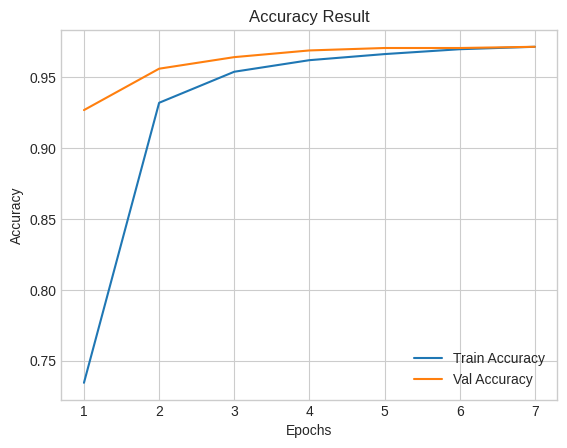

In [ ]:
plot.Relplot

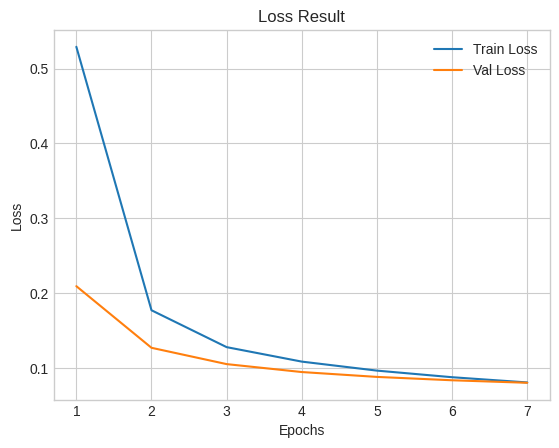

In [ ]:
plot.Falplot

#### `TensorFlow Lite`

Deploy Our Model on TensorFlow Lite

In [ ]:
ModelFolder = "/content/Modelite"

model.export(ModelFolder)

In [ ]:
tflite = tf.lite.TFLiteConverter

tflite_model = tflite.from_saved_model(ModelFolder)

tflite_model.optimizations = [tf.lite.Optimize.DEFAULT]

In [ ]:
tflite_model.inference_input_type, tflite_model.inference_output_type

(tf.float32, tf.float32)

In [ ]:
tflite_model = tflite_model.convert()

pathfile = "HartModel02.tflite"

tflite_model_file = pathlib.Path(pathfile)

tflite_model_file.write_bytes(tflite_model)

3382312

In [ ]:
os.path.getsize(pathfile) / float(2**20)

3.2256240844726562

In [ ]:
interpreter = tf.lite.Interpreter(model_path=pathfile)

interpreter.get_signature_list()

{'serving_default': {'inputs': ['keras_tensor'], 'outputs': ['output_0']}}

In [ ]:
lite_interpreter = interpreter.get_signature_runner('serving_default')

lite_interpreter

In [ ]:
test_images, test_labels = next(iter(test))

tensorlite_test = lite_interpreter(keras_tensor=test_images)['output_0']

tensorlite_test.shape

(128, 1)

In [ ]:
tensorlite_test[:1]

array([[0.9999915]], dtype=float32)

#### `TensorFlow Serving`

Deploy Our Model on TensorFlow Serving

In [ ]:
# Create Outlabel Layer to Use in TensorFlow Serving

class Outlabel(tf.keras.layers.Layer):
  def __init__(self):
    super(Outlabel, self).__init__()
    self.label = ["Cat", "Dog"]

  def call(self, inputs):
    tf.config.run_functions_eagerly(True)
    logits = tf.cast(tf.round(inputs), tf.int32)
    logits = tf.gather(self.label, logits)
    return logits

In [ ]:
# Modular Model to TensorFlow Serving

input_layer = model.input

modular = model(input_layer)

output_layer = Outlabel()(modular)

modular_server = tf.keras.Model(input_layer, output_layer)

modular_server.output

<KerasTensor shape=(None, 1), dtype=string, sparse=False, name=keras_tensor_89>

In [ ]:
tester = modular_server.predict(test_images, verbose=0)

tester[:3]

array([[b'Dog'],
       [b'Cat'],
       [b'Dog']], dtype=object)

In [ ]:
ModelFolder = "/content/ModelServer"

ModelSerial = "1"

ModuleFolder = os.path.join(ModelFolder, ModelSerial)

modular_server.export(ModuleFolder)

In [ ]:
os.environ["ModelFolder"] = ModelFolder

In [ ]:
!apt update

!apt-get install tensorflow-model-server

In [ ]:
%%bash --bg
nohup tensorflow_model_server \
  --rest_api_port=8501 \
  --model_name=inter_model \
  --model_base_path="${ModelFolder}" > server.log 2>&1

In [ ]:
!tail server.log

In [ ]:
import json, requests

test_img, test_label = next(iter(validation))

test_img = test_img.numpy().tolist()

url = "http://127.0.0.1:8501/v1/models/inter_model:predict"

In [ ]:
image = json.dumps({"signature_name":"serving_default", "instances":test_img})

content = {"content-type":"application/json"}

response = requests.post(url, data=image, headers=content)

loader = json.loads(response.text)

result = loader["predictions"]

result[:5]

[['Cat'], ['Dog'], ['Dog'], ['Cat'], ['Cat']]